# Spam Detection with Undersampling

In [1]:
import pandas as pd
import numpy as np
import random
import nltk
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Seed for reproducibility
seed_value = 123
np.random.seed(seed_value)
random.seed(seed_value)

## Load data

In [2]:
df = pd.read_csv('SMSSpamCollection.txt', sep='\t', header=None, names=['Label', 'Message'])

# Convert labels to numeric values
df['Target'] = df['Label'].map({'spam': 1, 'ham': 0})

print(df.shape)
df.head()

(5572, 3)


,Label,Message,Target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


#### Unbalanced dataset

In [3]:
class_counts = df['Label'].value_counts()
class_counts_df = class_counts.reset_index()
class_counts_df.columns = ['Class', 'Count']
class_counts_df['Percentage'] = ((class_counts_df['Count'] / class_counts_df['Count'].sum()) * 100).round(2)
class_counts_df

,Class,Count,Percentage
0,ham,4825,86.59
1,spam,747,13.41


## Text Preprocessing

**1. Pass to lowercase, remove punctuation and special characters and remove stopwords**

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jvg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jvg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
%%time
# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Get stopwords and define what stopwords to keep
stop_words = set(stopwords.words('english'))
important_stopwords = {"now", "today", "still", "soon", "only", "immediately", "urgent", "limited"}
custom_stop_words = stop_words - important_stopwords
processed_text = []

for text in df['Message']:
    # Lowercase
    text_lower = text.lower()
    
    # Replace number with the token NUM
    text_with_num = re.sub(r'\b\d+\b', 'NUM', text_lower)
    
    # Keep important symbols as currency symbols
    text_with_symbols = re.sub(r'[^a-zA-Z0-9£$€]', ' ', text_with_num)
    
    # Remove stopwords 
    words = text_with_symbols.split()
    words_without_stopwords = [word for word in words if word not in custom_stop_words]
    
    # Lemamtization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words_without_stopwords]    

    # Add processed text
    p_text = ' '.join(lemmatized_words)
    processed_text.append(p_text)
    
df['Message_processed'] = processed_text
df.head()

CPU times: user 1.55 s, sys: 55.3 ms, total: 1.61 s
Wall time: 1.61 s


,Label,Message,Target,Message_processed
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available only bugis n g...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry NUM wkly comp win fa cup final tkts...
3,ham,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf life around though


**2. Numbers**

In an analysis of spam and non-spam messages, numbers can be important.

**1. Frequency of numerical patterns in spam messages:** Spam messages often contain numbers, especially for discount codes, phone numbers, cash prizes, dates, and rates. Typical examples in spam include phrases like “You won £1000”, “Call 0800…”, “Get $500 now”, or “Up to 50% off”.

**2. Impact of numbers in non-spam messages:** In non-spam messages, numbers tend to appear less frequently, and when they do, they tend to be less consistent or relevant (such as mentioning a time or date with no significant value). Therefore, numbers in non-spam messages may not be as relevant as in spam messages.

**3. Options for number processing:** if we decide to keep the numbers we have to handle them in one of this two ways:
* **Keep numbers as is:** Leave numbers raw to allow the model to learn to recognize specific patterns in spam messages.
* **Replace numbers with a marker:** Instead of removing numbers, replace them with a token like NUM, so the model recognizes that there is a number without paying attention to its specific value.

As spam messages in our dataset often include numbers (prizes, fees, codes), it is a good idea to keep the numbers or replace them with a marker to help identify spam patterns. 

**3. Lemmatization**

Lemmatization returns words to their base form or stem, taking into account the grammatical context and meaning of the word (e.g. “better” → “good”, “running” → “run”). Lemmatization improves accuracy by distinguishing grammatical forms and words with different but related meanings (such as “better” vs “good”).

**Advantages:**
* Preserves the meaning of words and creates more readable and natural forms.
* More accurate than stemming because it uses information about the part of speech and context.

**Disadvantages:**
* Slower and more resource intensive.
* Requires knowledge of the language and may need additional training if the language or context is specific.

**4. Customised stopwords**

By removing stopwords (such as “now”, “been”, “still”), the text is reduced, but some relevant elements of context were lost. The words “been” and “now”, for example, add a sense of urgency to the original message. So, we have kept certain stopwords that provide context for this type of messages.

## Embeddings

### BERT

In [6]:
%%time
from transformers import BertTokenizer, BertModel

# Load the tokenizer and pretrained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

2024-11-19 18:57:07.762113: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 18:57:07.770375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732039027.779878    9726 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732039027.782699    9726 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 18:57:07.793109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

CPU times: user 1.26 s, sys: 99.3 ms, total: 1.36 s
Wall time: 1.84 s


In [7]:
# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [8]:
def get_bert_embeddings_batch(texts, batch_size):
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenize and move to GPU
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Extract CLS token embeddings and move back to CPU
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(embeddings)

    # Concatenate all batch embeddings
    return np.concatenate(all_embeddings, axis=0)

In [9]:
%%time
batch_size = 8
texts = df['Message_processed'].tolist()  
bert = get_bert_embeddings_batch(texts, batch_size)

CPU times: user 7.94 s, sys: 83.4 ms, total: 8.02 s
Wall time: 8.02 s


In [10]:
print(f'{type(bert)} \n {bert.shape}')

<class 'numpy.ndarray'> 
 (5572, 768)


### TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
# List of processed SMS messages
texts = df['Message_processed'].tolist()  

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Transform the text data into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Convert the TF-IDF matrix into a DataFrame for better inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df.head()

,0776xxxxxxx,077xxx,0789xxxxxxx,0796xxxxxx,07xxxxxxxxx,08452810075over18,08700435505150p,08700621170150p,08701417012150p,08704439680ts,...,yupz,zac,zaher,zealand,zebra,zed,zero,zhong,zindgi,zoe
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.243024,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SBERT (Sentence-BERT)

In [6]:
from sentence_transformers import SentenceTransformer

In [7]:
%%time
model = SentenceTransformer('all-MiniLM-L6-v2')
sbert = model.encode(df['Message_processed'].tolist())

CPU times: user 8.89 s, sys: 3.5 s, total: 12.4 s
Wall time: 8.92 s


In [8]:
print(f'{type(sbert)} \n {sbert.shape}')

<class 'numpy.ndarray'> 
 (5572, 384)


### USE (Universal Sentence Encoder)

* What it is: Developed by Google, USE provides embeddings optimized for sentence-level semantic similarity.
* Why it might help: USE is known for its simplicity and relatively low computation costs. It’s also effective for tasks where capturing sentence-level meaning is critical

In [42]:
import tensorflow_hub as hub

2024-11-18 10:45:15.140114: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 10:45:15.156251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731923115.174025    9656 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731923115.179182    9656 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 10:45:15.197694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [43]:
%%time
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
use = model(df['Message_processed'].tolist()).numpy()

W0000 00:00:1731923249.586971    9656 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-11-18 10:47:35.718099: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


CPU times: user 56.9 s, sys: 8.12 s, total: 1min 5s
Wall time: 2min 13s


In [ ]:
print(f'{type(use)} \n {use.shape}')

## Data Transformation

### PCA

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(bert)

In [13]:
from sklearn.decomposition import PCA

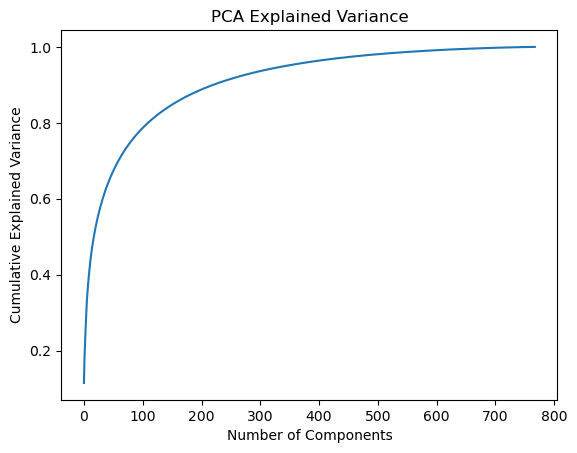

CPU times: user 12.9 s, sys: 147 ms, total: 13 s
Wall time: 783 ms


In [15]:
%%time
# Get explained variance ratio
pca = PCA(n_components=768)
pca.fit(scaled_data)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative explained variance
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

In [16]:
%%time
# Apply PCA to reduce dimensionality
pca = PCA(n_components=200) # 200 components because it captures almost 90% 
embeddings_pca = pca.fit_transform(scaled_data)

# Check the new shape
print(embeddings_pca.shape)

(5572, 200)
CPU times: user 23.9 s, sys: 9.12 s, total: 33 s
Wall time: 1.75 s


### Undersampling

In [17]:
from imblearn.under_sampling import RandomUnderSampler

In [18]:
# Initialize RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling
X_resampled, y_resampled = under_sampler.fit_resample(embeddings_pca, df['Target'])

pd.Series(y_resampled).value_counts()

Target
0    747
1    747
Name: count, dtype: int64

In [19]:
under_df = pd.DataFrame(y_resampled)

## Clustering tendency

### 1. Distance Matrix and Heatmap

The choice of a distance measure depends on the data type and distribution. Since FIFA player data includes continuous, scaled numerical features (e.g., attributes like passing, shooting, pace), Euclidean distance is often a natural choice because:

* Interpretability: Euclidean distance allows us to interpret clusters as players with similar skills in a multi-dimensional space.
* Continuous Data: Euclidean is appropriate for continuous, numeric data (assuming no binary or categorical data remains after preprocessing).

In [20]:
from scipy.spatial.distance import pdist, squareform

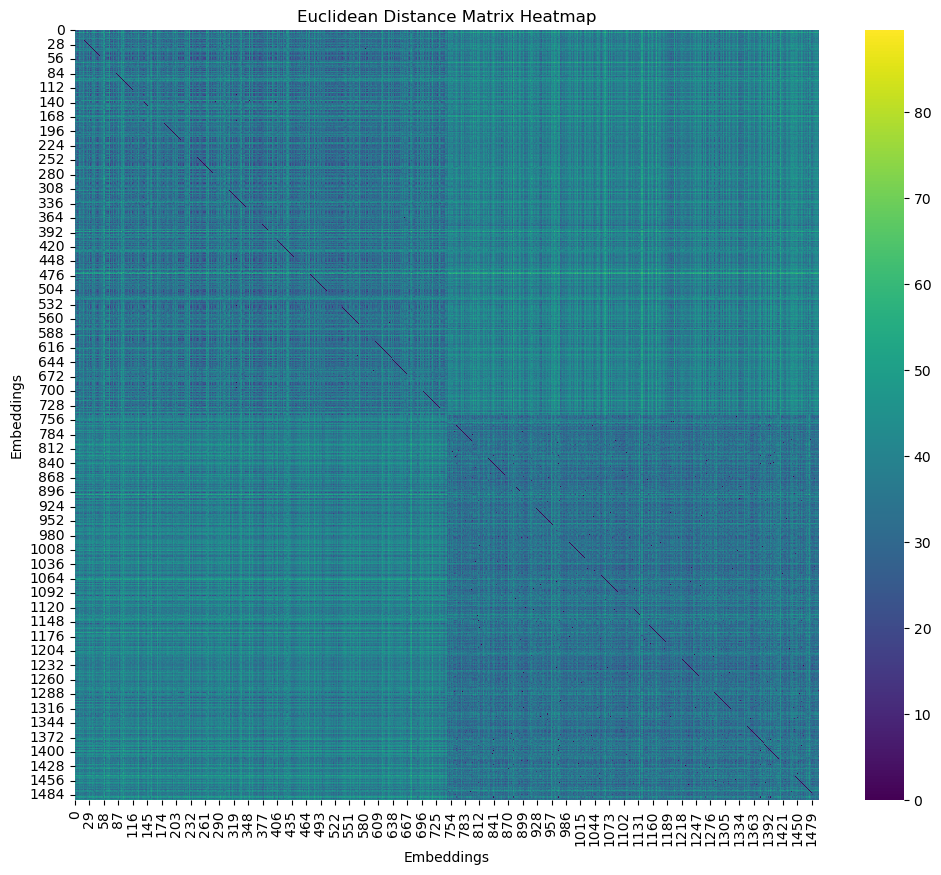

CPU times: user 1.29 s, sys: 212 ms, total: 1.5 s
Wall time: 1.3 s


In [21]:
%%time
# Distance matrix with Euclidean distance
distance_matrix = squareform(pdist(X_resampled, metric='euclidean'))

# Heatmap for the Euclidean distance matrix
plt.figure(figsize=(12, 10))
hm = sns.heatmap(distance_matrix, cmap="viridis")
hm.set_title("Euclidean Distance Matrix Heatmap")
hm.set_xlabel("Embeddings")
hm.set_ylabel("Embeddings")
plt.show()

### 2. Hopkins statistic

In [22]:
# Original: https://github.com/prathmachowksey/Hopkins-Statistic-Clustering-Tendency/blob/master/Hopkins-Statistic-Clustering-Tendency.ipynb
# function to compute hopkins's statistic for the dataframe X

def hopkins_statistic(X, sample_size):
    from numpy.random import uniform
    from random import sample
    from sklearn.neighbors import NearestNeighbors

    # Generate a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0), (sample_size, X.shape[1]))

    # Select a random sample of size sample_size from the original data X
    random_indices = sample(range(0, X.shape[0]), sample_size)
    X_sample = X[random_indices]

    # Initialize nearest neighbors
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)

    # Nearest neighbor distances for uniform random sample
    u_distances, _ = nbrs.kneighbors(X_uniform_random_sample, n_neighbors=2)
    u_distances = u_distances[:, 0]  # Distance to the nearest neighbor

    # Nearest neighbor distances for X sample
    w_distances, _ = nbrs.kneighbors(X_sample, n_neighbors=2)
    w_distances = w_distances[:, 1]  # Distance to the second-nearest neighbor

    # Calculate Hopkins statistic
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    H = u_sum / (u_sum + w_sum)
    return H

In [23]:
from sklearn.utils import check_random_state

In [24]:
%%time
# Set parameters
np.random.seed(100)
myN = [20, 35, 50, 65]  # Sample sizes
myhopkins = []

# Generate seeds
myseed = np.random.choice(range(1, 1001), 10, replace=False)

# Calculate Hopkins statistic for each n in myN and each seed
for n in myN:
    for seed in myseed:
        rng = check_random_state(seed)
        hopkins_stat = hopkins_statistic(X_resampled, sample_size=n)
        myhopkins.append(hopkins_stat)

# Display summary statistics
print(pd.Series(myhopkins).describe())

count    40.000000
mean      0.777103
std       0.021059
min       0.741235
25%       0.761679
50%       0.774028
75%       0.793109
max       0.829970
dtype: float64
CPU times: user 2 s, sys: 4.68 s, total: 6.68 s
Wall time: 367 ms


## Hierarchical Methods
1. Ward Method
2. Average Method

### 1. Ward Method

In [25]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

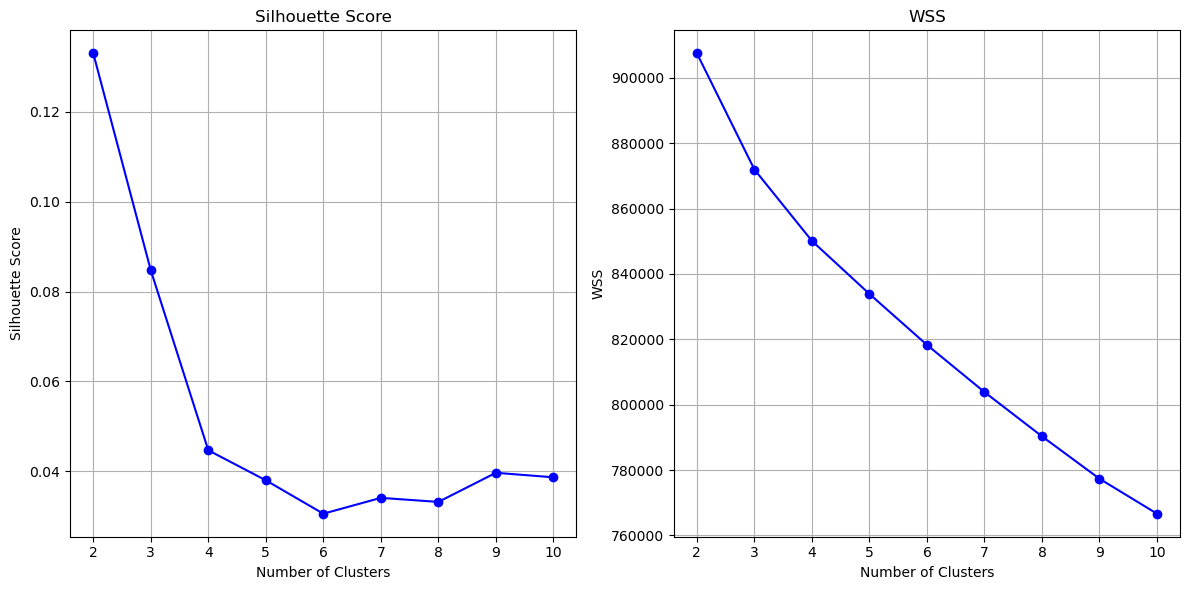

CPU times: user 2.24 s, sys: 4.13 s, total: 6.37 s
Wall time: 482 ms


In [26]:
%%time
Z = linkage(X_resampled, method='ward')

# Evaluate the clustering for different values of k
k_range = range(2, 11)  
silhouette_scores = []
wss = []

for k in k_range:
    # Generate the clusters for each k
    clusters = fcluster(Z, t=k, criterion='maxclust')
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X_resampled, clusters)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate the WSS (Within-Cluster Sum of Squares)
    wss_value = 0
    for i in range(1, k+1):
        cluster_data = X_resampled[clusters == i]
        cluster_center = cluster_data.mean(axis=0)
        wss_value += np.sum(np.linalg.norm(cluster_data - cluster_center, axis=1)**2)
    wss.append(wss_value)

# Plot the results
plt.figure(figsize=(12, 6))

# Silhouette score plot
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

# WSS plot
plt.subplot(1, 2, 2)
plt.plot(k_range, wss, marker='o', linestyle='-', color='b')
plt.title('WSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

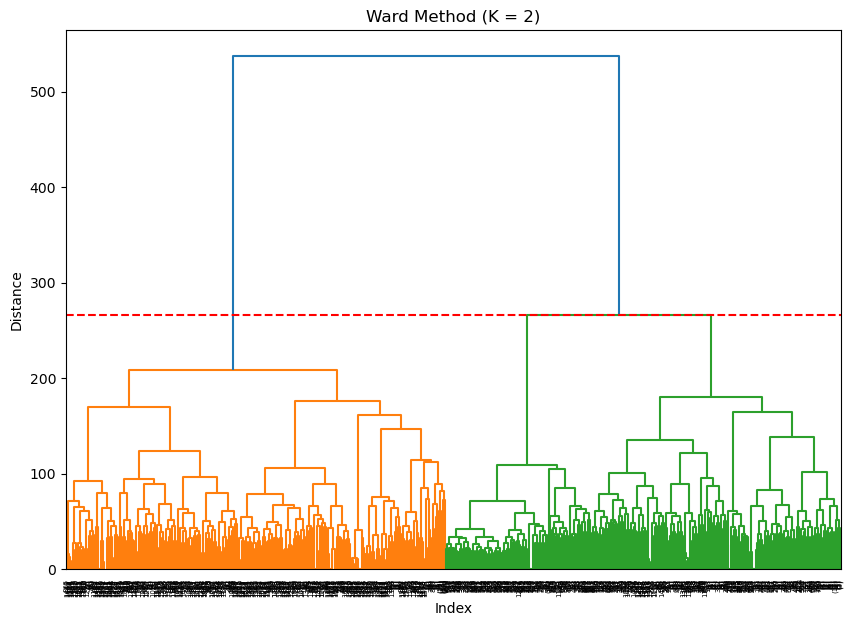

CPU times: user 2.36 s, sys: 321 ms, total: 2.68 s
Wall time: 2.28 s


In [28]:
%%time
n_clusters = 2
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
under_df['cluster_ward'] = ward.fit_predict(X_resampled)

## Dendrogram ##

# Largest "jump" in the distances 
distances = Z[:, 2]  # 3rd col of the linkage matrix contains the distances

# Computation of the differences between consecutive distances
diff = np.diff(distances)
max_diff_index = np.argmax(diff)
cutoff_distance = distances[max_diff_index]  # The distance at which the largest jump occurs

# Plot dendogram
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=10)
plt.axhline(y=cutoff_distance, color='r', linestyle='--')  # Cutoff level based on max jump
plt.title(f"Ward Method (K = {n_clusters})")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

##### Ward Method + PCA Projection

In [29]:
from sklearn.decomposition import PCA
import plotly.express as px

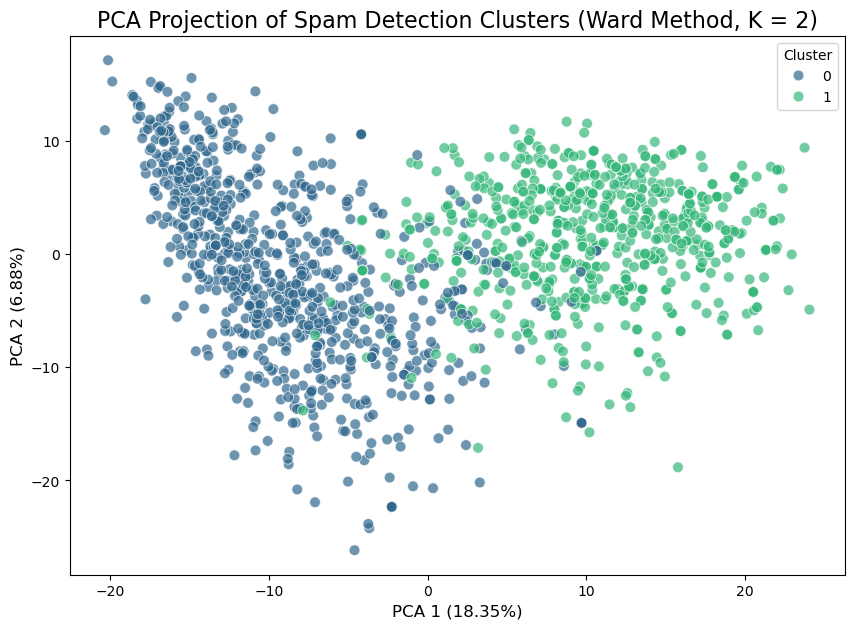

In [30]:
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_resampled)

# Create a DataFrame for PCA results with cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = under_df['cluster_ward']


# Plot the PCA projection, color the points by the cluster labels
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='viridis', s=60, alpha=0.7)
plt.title(f"PCA Projection of Spam Detection Clusters (Ward Method, K = {n_clusters})", fontsize=16)
plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
plt.legend(title="Cluster", loc="upper right")
plt.show()

In [31]:
import plotly.io as pio

In [32]:
# Apply PCA to reduce to 3D for visualization (n_components=3)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_resampled)

# Create a DataFrame for PCA results with cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['cluster'] = under_df['cluster_ward']

# Set the renderer to browser
pio.renderers.default = "browser"

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(pca_df, x='PCA1', y='PCA2', z='PCA3', color='cluster', 
                    title="3D PCA Projection of Spam Detection Clusters (Ward Method)",
                    labels={'PCA1': f'PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)', 
                            'PCA2': f'PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', 
                            'PCA3': f'PCA 3 ({pca.explained_variance_ratio_[2]*100:.2f}%)'},
                    color_continuous_scale='viridis')

fig.update_traces(marker=dict(size=3)) 

# Show the plot
fig.show()

### 2. Average Method

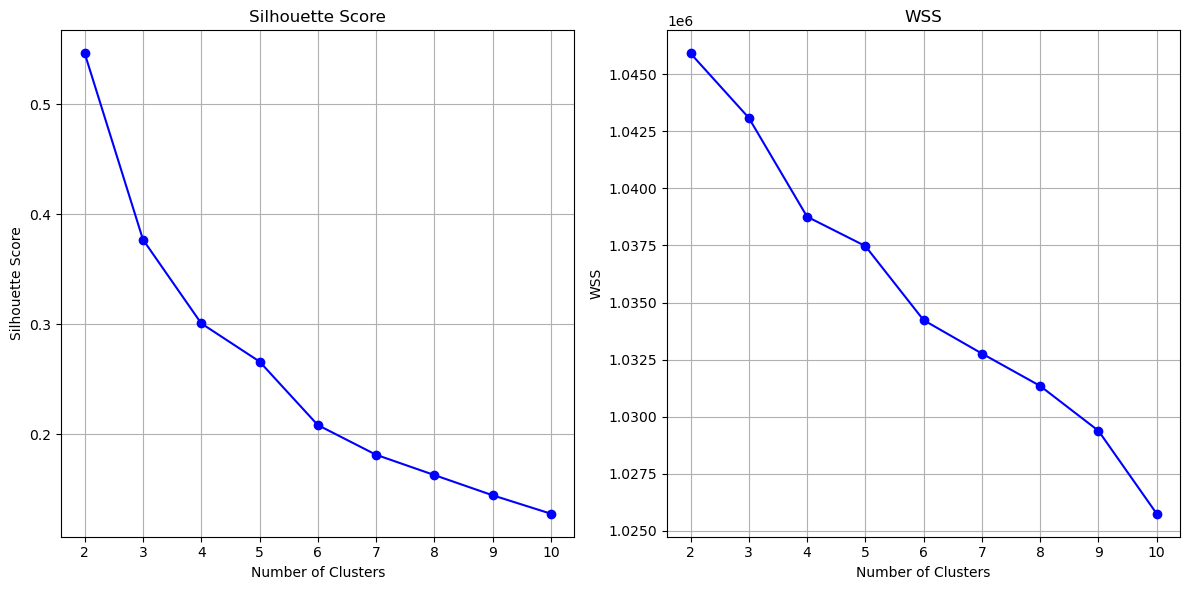

CPU times: user 2.18 s, sys: 4.2 s, total: 6.38 s
Wall time: 452 ms


In [33]:
%%time
Z = linkage(X_resampled, method='average')

# Evaluate the clustering for different values of k
k_range = range(2, 11)  
silhouette_scores = []
wss = []

for k in k_range:
    # Generate the clusters for each k
    clusters = fcluster(Z, t=k, criterion='maxclust')
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X_resampled, clusters)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate the WSS (Within-Cluster Sum of Squares)
    wss_value = 0
    for i in range(1, k+1):
        cluster_data = X_resampled[clusters == i]
        cluster_center = cluster_data.mean(axis=0)
        wss_value += np.sum(np.linalg.norm(cluster_data - cluster_center, axis=1)**2)
    wss.append(wss_value)

# Plot the results
plt.figure(figsize=(12, 6))

# Silhouette score plot
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

# WSS plot
plt.subplot(1, 2, 2)
model = AgglomerativeClustering(linkage='average', metric='euclidean')
plt.plot(k_range, wss, marker='o', linestyle='-', color='b')
plt.title('WSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS')
plt.grid(True)
plt.tight_layout()
plt.show()

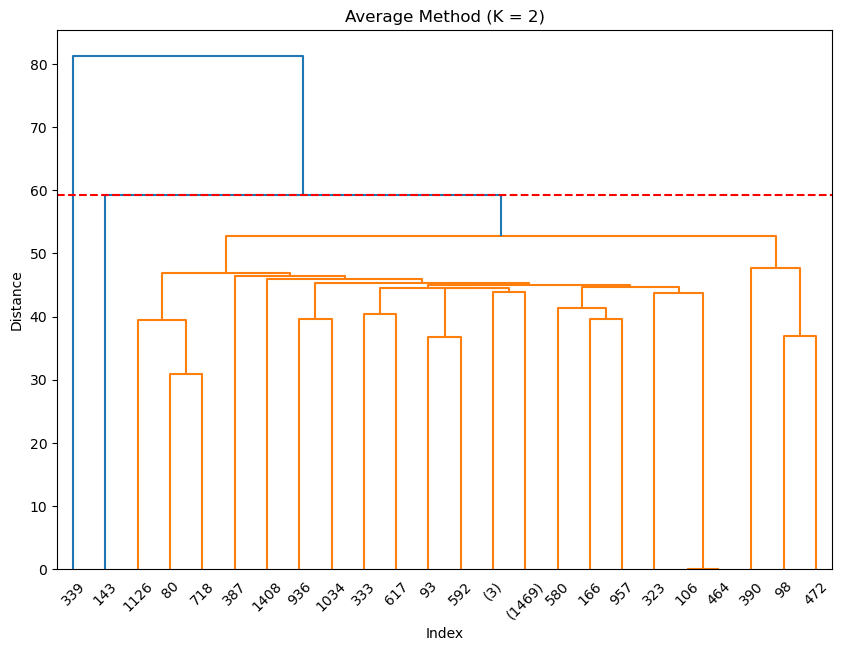

CPU times: user 234 ms, sys: 136 ms, total: 370 ms
Wall time: 184 ms


In [34]:
%%time
n_clusters = 2
average = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
under_df['cluster_average'] = average.fit_predict(X_resampled)

## Dendrogram ##

# Largest "jump" in the distances 
distances = Z[:, 2]  # 3rd col of the linkage matrix contains the distances

# Computation of the differences between consecutive distances
diff = np.diff(distances)
max_diff_index = np.argmax(diff)
cutoff_distance = distances[max_diff_index]  # The distance at which the largest jump occurs

# Plot dendogram
plt.figure(figsize=(10, 7))
dendrogram(Z,  truncate_mode='level', p=10)
plt.axhline(y=cutoff_distance, color='r', linestyle='--')  # Cutoff level based on max jump
plt.title(f"Average Method (K = {n_clusters})")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

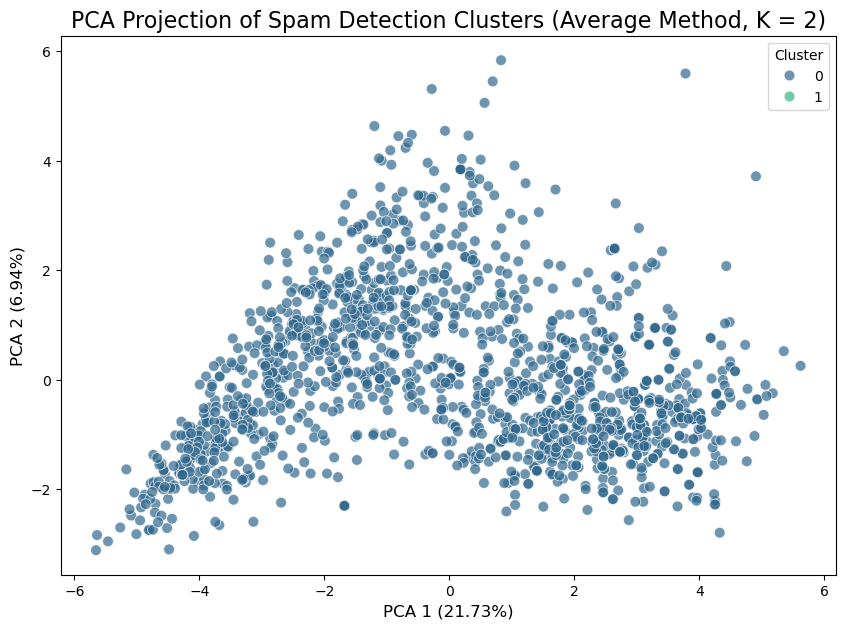

In [29]:
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_resampled)

# Create a DataFrame for PCA results with cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = under_df['cluster_average']


# Plot the PCA projection, color the points by the cluster labels
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='viridis', s=60, alpha=0.7)
plt.title(f"PCA Projection of Spam Detection Clusters (Average Method, K = {n_clusters})", fontsize=16)
plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
plt.legend(title="Cluster", loc="upper right")
plt.show()

In [35]:
# Apply PCA to reduce to 3D for visualization (n_components=3)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_resampled)

# Create a DataFrame for PCA results with cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['cluster'] = under_df['cluster_average']

# Set the renderer to browser
pio.renderers.default = "browser"

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(pca_df, x='PCA1', y='PCA2', z='PCA3', color='cluster', 
                    title="3D PCA Projection of Spam Detection Clusters (Average Method)",
                    labels={'PCA1': f'PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)',
                            'PCA2': f'PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', 
                            'PCA3': f'PCA 3 ({pca.explained_variance_ratio_[2]*100:.2f}%)'},
                    color_continuous_scale='viridis')

fig.update_traces(marker=dict(size=3)) 

# Show the plot
fig.show()

## Partition Methods
1. K-Means

### 1. K-Means

In [36]:
from sklearn.cluster import KMeans

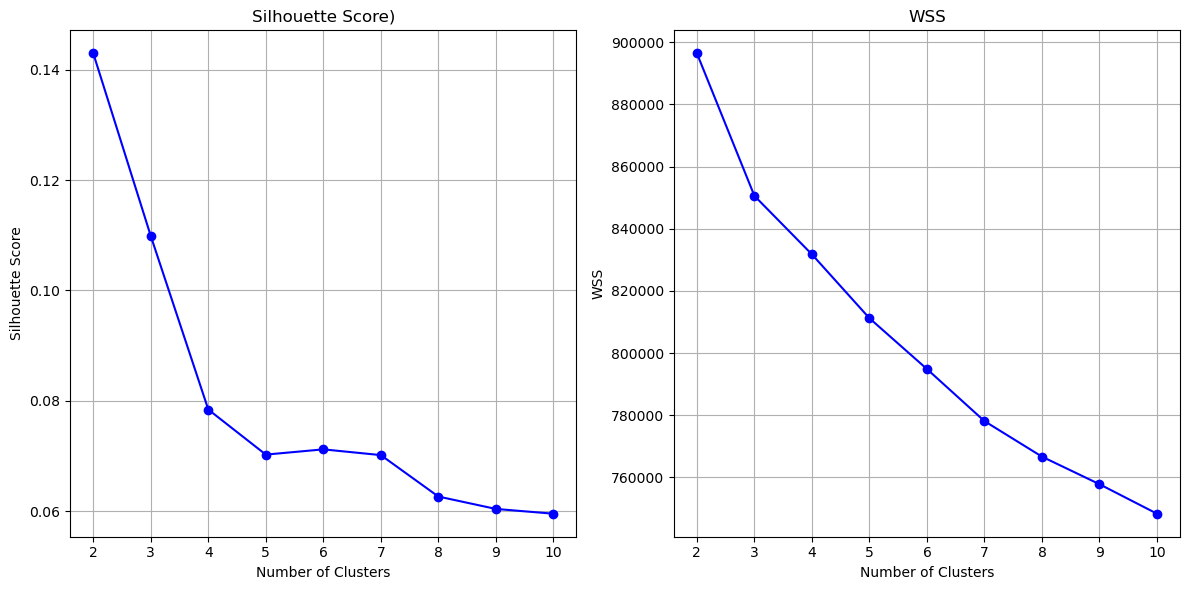

CPU times: user 2.78 s, sys: 5.73 s, total: 8.5 s
Wall time: 540 ms


In [37]:
%%time
# Store evaluation metrics
k_range = range(2, 11)  
silhouette_scores = []
wss = []

# Loop over different values of k
for k in k_range:
    # Apply K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_resampled)
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X_resampled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate the WSS (Within-Cluster Sum of Squares)
    wss.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(12, 6))

# Silhouette score plot
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

# WSS plot
plt.subplot(1, 2, 2)
plt.plot(k_range, wss, marker='o', linestyle='-', color='b')
plt.title('WSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS')
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_resampled)
under_df['cluster_kmeans'] = kmeans.labels_

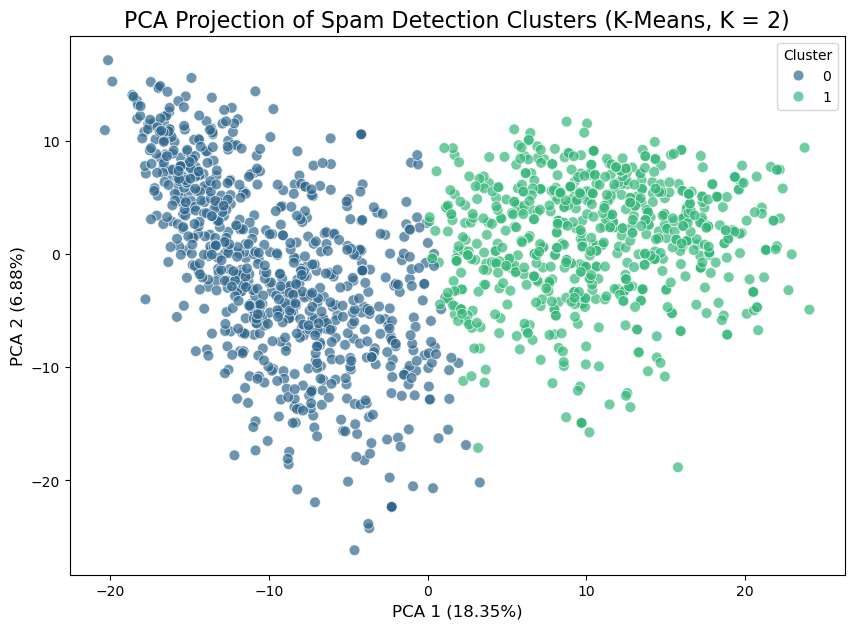

In [39]:
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_resampled)

# Create a DataFrame for PCA results with cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = under_df['cluster_kmeans']

# Plot the PCA projection, color the points by the cluster labels
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='viridis', s=60, alpha=0.7)
plt.title(f"PCA Projection of Spam Detection Clusters (K-Means, K = {n_clusters})", fontsize=16)
plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
plt.legend(title="Cluster", loc="upper right")
plt.show()

In [41]:
# Apply PCA to reduce to 3D for visualization (n_components=3)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_resampled)

# Create a DataFrame for PCA results with cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['cluster'] = under_df['cluster_kmeans']

# Set the renderer to browser
pio.renderers.default = "browser"

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(pca_df, x='PCA1', y='PCA2', z='PCA3', color='cluster', 
                    title="3D PCA Projection of Spam Detection Clusters (KMeans)",
                    labels={'PCA1': f'PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)',
                            'PCA2': f'PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', 
                            'PCA3': f'PCA 3 ({pca.explained_variance_ratio_[2]*100:.2f}%)'},
                    color_continuous_scale='viridis')

fig.update_traces(marker=dict(size=3)) 

# Show the plot
fig.show()

## Probabilistic Model
1. GMM (Gaussian Mixture Model)

### 1. GMM 

In [42]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import pairwise_distances

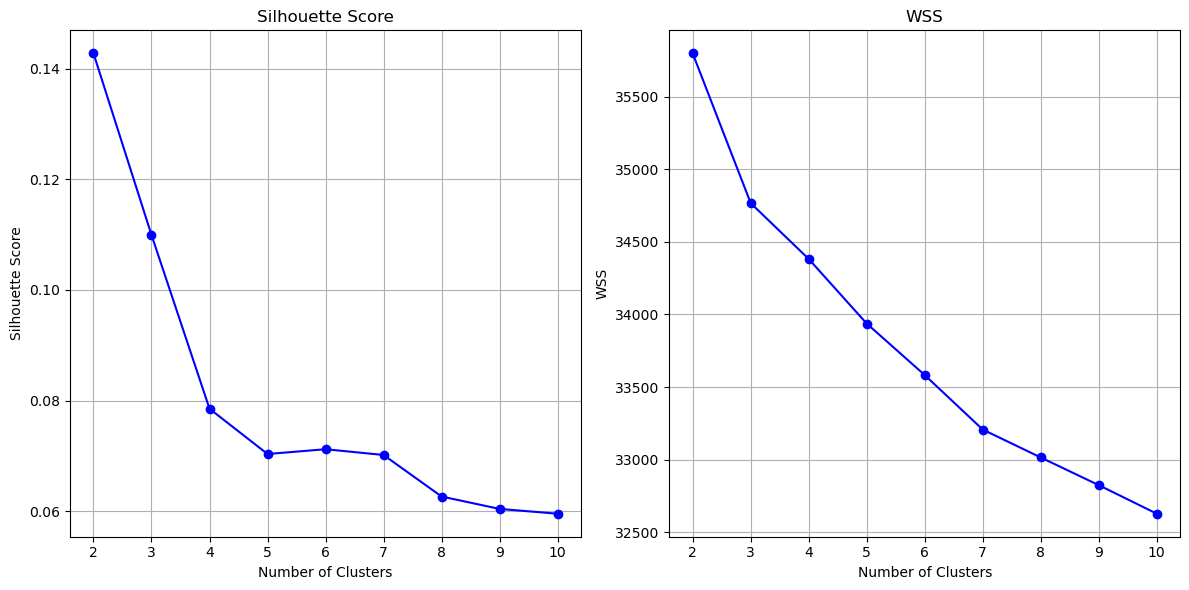

CPU times: user 1min 32s, sys: 1min 2s, total: 2min 34s
Wall time: 7.99 s


In [43]:
%%time
# Initialize variables to store evaluation metrics
k_range = range(2, 11)  # Trying k from 2 to 10 clusters
silhouette_scores = []
wss = []

# Loop over different values of k
for k in k_range:
    # Apply Gaussian Mixture Model clustering
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_resampled)
    
    # Get the soft assignment probabilities for each point
    prob = gmm.predict_proba(X_resampled)
    
    # Get the hard labels by picking the cluster with the highest probability for each sample
    labels = np.argmax(prob, axis=1)
    
    # Calculate the silhouette score using hard labels (you could compute soft silhouette score as well)
    silhouette_avg = silhouette_score(X_resampled, labels)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate the WSS (Within-Cluster Sum of Squares) using the cluster means and distances
    cluster_means = gmm.means_
    distance_matrix = pairwise_distances(X_resampled, cluster_means, metric='euclidean')
    wss_value = np.sum(np.min(distance_matrix, axis=1))  # Sum of minimum distances to the cluster means
    wss.append(wss_value)

# Plot the results
plt.figure(figsize=(12, 6))

# Silhouette score plot
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

# WSS plot
plt.subplot(1, 2, 2)
plt.plot(k_range, wss, marker='o', linestyle='-', color='b')
plt.title('WSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS')
plt.grid(True)

plt.tight_layout()
plt.show()

In [44]:
%%time
n_clusters = 2
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(X_resampled)
prob = gmm.predict_proba(X_resampled)
under_df['cluster_gmm'] = np.argmax(prob, axis=1)

CPU times: user 7.99 s, sys: 5.48 s, total: 13.5 s
Wall time: 713 ms


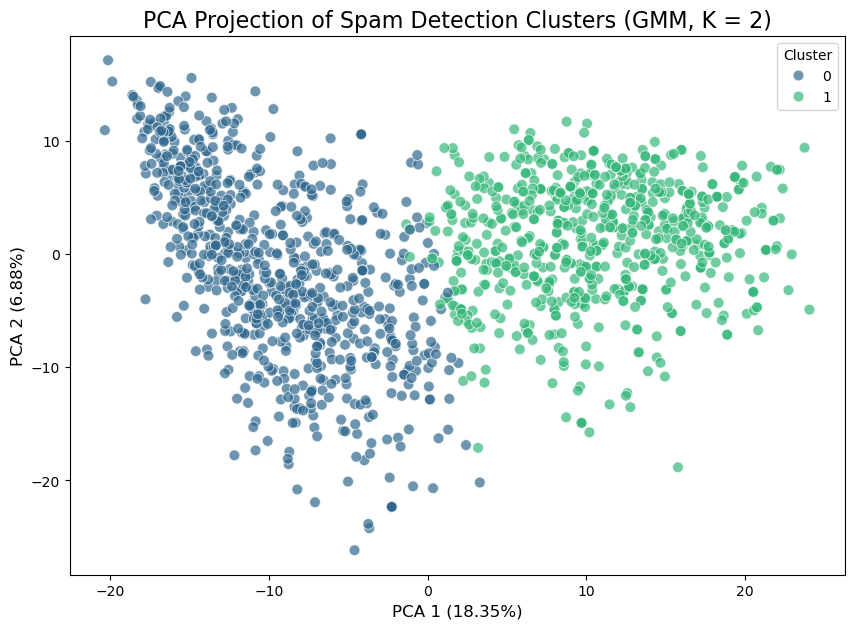

In [45]:
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_resampled)

# Create a DataFrame for PCA results with cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = under_df['cluster_gmm']

# Plot the PCA projection, color the points by the cluster labels
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='viridis', s=60, alpha=0.7)
plt.title(f"PCA Projection of Spam Detection Clusters (GMM, K = {n_clusters})", fontsize=16)
plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=12)
plt.legend(title="Cluster", loc="upper right")
plt.show()

In [46]:
# Apply PCA to reduce to 3D for visualization (n_components=3)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_resampled)

# Create a DataFrame for PCA results with cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['cluster'] = under_df['cluster_gmm']

# Set the renderer to browser
pio.renderers.default = "browser"

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(pca_df, x='PCA1', y='PCA2', z='PCA3', color='cluster', 
                    title="3D PCA Projection of Spam Detection Clusters (GMM)",
                    labels={'PCA1': f'PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)',
                            'PCA2': f'PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)',
                            'PCA3': f'PCA 3 ({pca.explained_variance_ratio_[2]*100:.2f}%)'},
                    color_continuous_scale='viridis')

fig.update_traces(marker=dict(size=3)) 

# Show the plot
fig.show()

## Selection and Validation of the Clustering Method
* Ward Method
* Average Method
* KMeans
* GMM

In [42]:
from scipy.spatial.distance import cdist

In [43]:
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    intra_cluster_distances = []
    inter_cluster_distances = []

    for i in unique_labels:
        # Points in cluster i
        cluster_i = X[labels == i]
        
        # Intra-cluster distance: Max distance between points in the same cluster
        dist_matrix_i = cdist(cluster_i, cluster_i, 'euclidean')
        intra_cluster_distances.append(np.max(dist_matrix_i))

        for j in unique_labels:
            if i < j:  # Only compute inter-cluster distances once
                # Points in cluster j
                cluster_j = X[labels == j]
                
                # Inter-cluster distance: Min distance between points from different clusters
                dist_matrix_ij = cdist(cluster_i, cluster_j, 'euclidean')
                inter_cluster_distances.append(np.min(dist_matrix_ij))
    
    # Return Dunn index: min inter-cluster distance / max intra-cluster distance
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

In [44]:
def average_proportion_non_overlapping(X, labels):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    n_samples = X.shape[0]
    APN = 0
    
    for i in range(n_samples):
        xi = X[i]
        cluster_i = labels[i]
        
        # Distance of xi to the centroid of its cluster
        dist_to_own_cluster = np.linalg.norm(xi - np.mean(X[labels == cluster_i], axis=0))
        
        # Calculate distances to centroids of other clusters
        dist_to_other_clusters = [
            np.linalg.norm(xi - np.mean(X[labels == cluster_j], axis=0)) 
            for cluster_j in unique_labels if cluster_j != cluster_i
        ]
        
        # APN calculation: check how close xi is to the center of its own cluster compared to others
        APN += np.sum(np.array(dist_to_own_cluster) < np.array(dist_to_other_clusters)) / (n_clusters - 1)
    
    return APN / n_samples

In [45]:
def average_distance(X, labels):
    unique_labels = np.unique(labels)
    total_distance = 0
    n_samples = X.shape[0]
    
    for i in unique_labels:
        cluster_points = X[labels == i]
        cluster_centroid = np.mean(cluster_points, axis=0)
        total_distance += np.sum(np.linalg.norm(cluster_points - cluster_centroid, axis=1))
    
    return total_distance / n_samples

In [46]:
def average_distance_between_means(X, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([np.mean(X[labels == i], axis=0) for i in unique_labels])
    n_centroids = len(centroids)
    
    total_distance = 0
    for i in range(n_centroids):
        for j in range(i + 1, n_centroids):
            total_distance += np.linalg.norm(centroids[i] - centroids[j])
    
    return total_distance / (n_centroids * (n_centroids - 1) / 2)

In [47]:
def figure_of_merit(X, labels):
    unique_labels = np.unique(labels)
    intra_cluster_variance = 0
    inter_cluster_variance = 0
    n_samples = X.shape[0]
    
    centroids = np.array([np.mean(X[labels == i], axis=0) for i in unique_labels])
    
    # Intra-cluster variance
    for i in unique_labels:
        cluster_points = X[labels == i]
        cluster_centroid = centroids[i]
        intra_cluster_variance += np.sum(np.linalg.norm(cluster_points - cluster_centroid, axis=1)**2)
    
    # Inter-cluster variance
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            inter_cluster_variance += np.linalg.norm(centroids[i] - centroids[j])**2
    
    # FOM calculation
    return intra_cluster_variance / inter_cluster_variance

In [48]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

In [49]:
%%time
metrics_data = []
methods = {'Ward':ward,
            'KMeans':kmeans,
           'Average':average,
           'GMM':gmm}

for name, model in methods.items():
    if name == 'GMM':    
        labels = model.fit(X_resampled).predict(X_resampled)
    else:
        labels = model.fit(X_resampled).labels_
    
    # Calculate validation metrics
    silhouette_avg = silhouette_score(X_resampled, labels)
    db_index = davies_bouldin_score(X_resampled, labels)
    dunn = dunn_index(X_resampled, labels) 
    apn = average_proportion_non_overlapping(X_resampled, labels)
    ad = average_distance(X_resampled, labels)
    adm = average_distance_between_means(X_resampled, labels)
    fom = figure_of_merit(X_resampled, labels)
    
    # Store the results
    metrics_data.append({
        "Method": name,
        "Clusters": len(np.unique(labels)),
        "Silhouette Score": silhouette_avg,
        "Davies-Bouldin Index": db_index,
        "Dunn Index": dunn,
        "APN": apn,
        "AD": ad,
        "ADM": adm,
        "FOM": fom
    })

CPU times: user 31.3 s, sys: 21.8 s, total: 53.1 s
Wall time: 12.1 s


In [50]:
metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Method,Clusters,Silhouette Score,Davies-Bouldin Index,Dunn Index,APN,AD,ADM,FOM
0,Ward,2,0.143451,2.316693,0.202310,0.933066,5.021469,4.329456,2098.792297
1,KMeans,2,0.156073,2.200732,0.145511,1.000000,4.981234,4.526391,1887.555415
2,Average,2,0.538165,0.346049,0.985151,1.000000,5.470458,15.818908,184.087412
3,GMM,2,0.156073,2.200732,0.145511,1.000000,4.981234,4.526391,1887.555415


* Silhouette Score: Higher is better (close to 1).
* Davies-Bouldin Index: Lower is better.
* Dunn Index: Higher is better.
* APN: Higher is better (close to 1).
* AD: Lower is better.
* ADM: Lower is better.
* FOM: Lower is better.

In [51]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

In [52]:
def plot_silhouette(X, labels, title):
    """
    Generates a silhouette plot for clustering results.
    
    Parameters:
    - X: Data points used for clustering.
    - labels: Cluster labels for each data point.
    - title: Title for the silhouette plot.
    """
    n_clusters = len(np.unique(labels))
    silhouette_vals = silhouette_samples(X, labels)
    y_lower, y_upper = 0, 0
    yticks = []

    # Define colors
    colors = cm.nipy_spectral(np.linspace(0, 1, n_clusters))
    plt.figure(figsize=(10, 7))

    for i, color in zip(range(n_clusters), colors):
        # Aggregate silhouette scores for the cluster
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()

        # Compute the silhouette range for this cluster
        y_upper += len(cluster_silhouette_vals)
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)
        yticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)

    # Average silhouette score
    silhouette_avg = silhouette_score(X, labels)
    plt.axvline(silhouette_avg, color="red", linestyle="--")

    plt.yticks(yticks, [f"Cluster {i+1}" for i in range(n_clusters)])
    plt.ylabel("Cluster")
    plt.xlabel("Silhouette Score")
    plt.title(f"Silhouette Plot: {title}")
    plt.show()

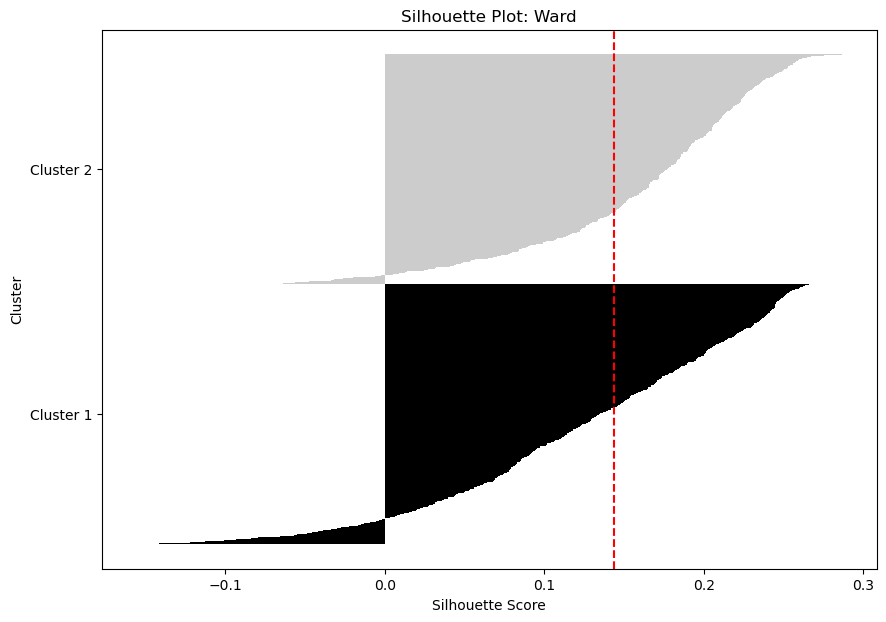

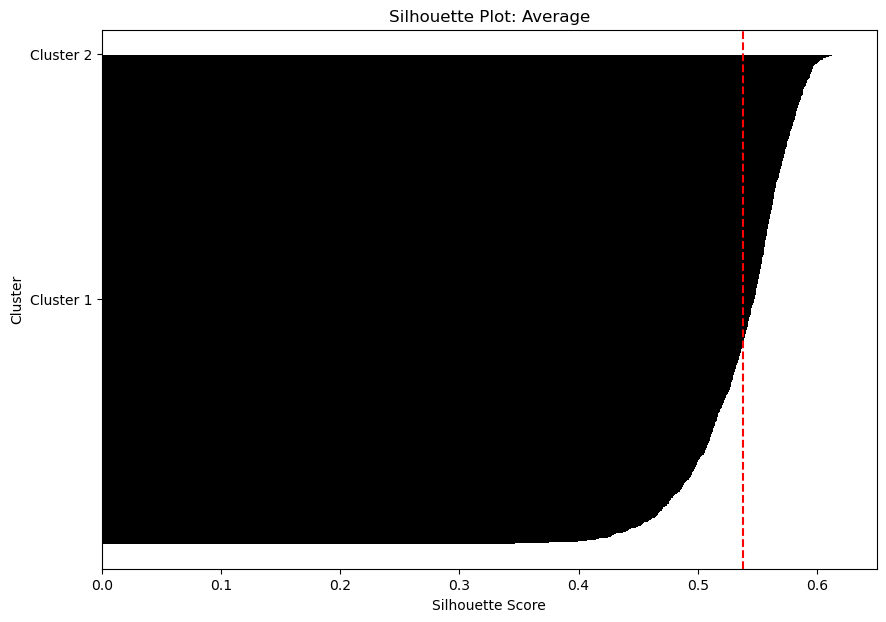

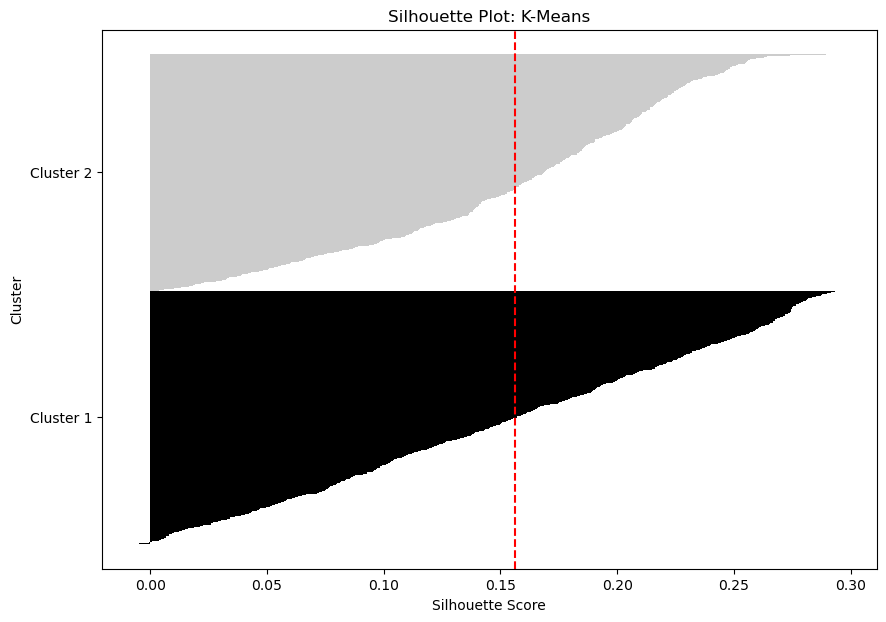

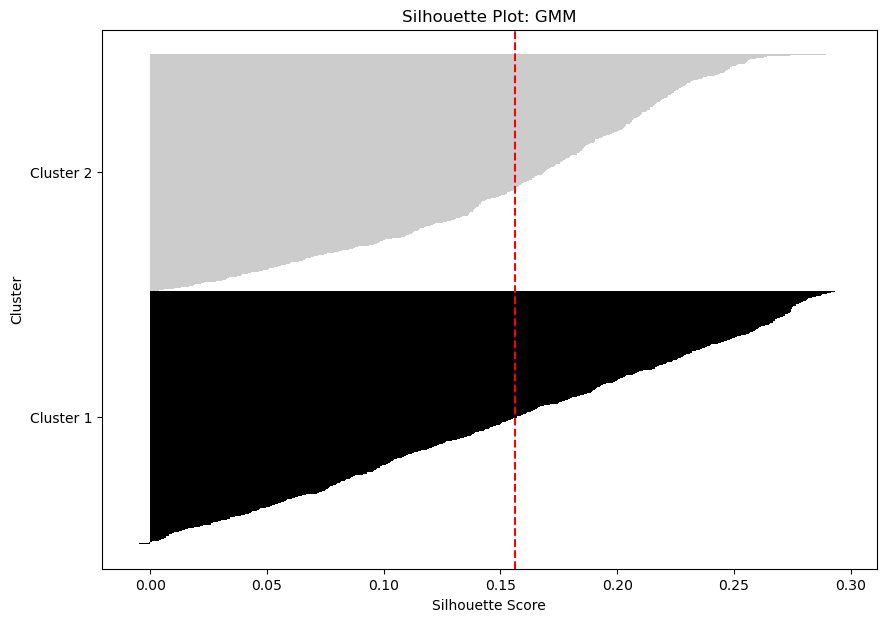

In [53]:
clustering_methods = {
    "Ward": under_df['cluster_ward'],
    "Average": under_df['cluster_average'],
    "K-Means": under_df['cluster_kmeans'],
    "GMM": under_df['cluster_gmm']
}

for method, labels in clustering_methods.items():
    plot_silhouette(X_resampled, labels, title=method)

## Cluster Evaluation

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

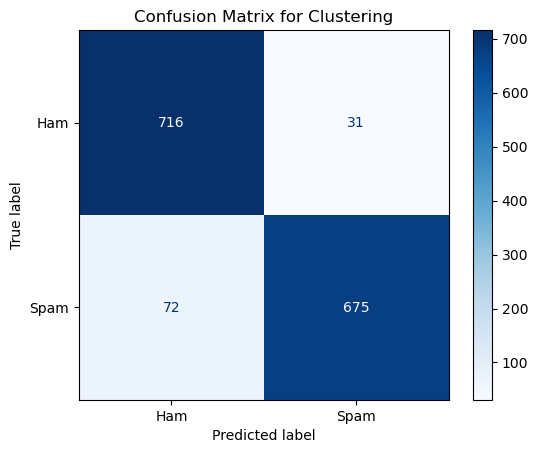

In [48]:
conf_matrix = confusion_matrix(under_df['Target'], under_df['cluster_kmeans'])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Clustering')
plt.show()

* For the 747 HAM messages:
    * 716 are correct
    * 31 are wrong
* For the 747 SPAM messages:
    * 675 are correct
    * 72 are wrong

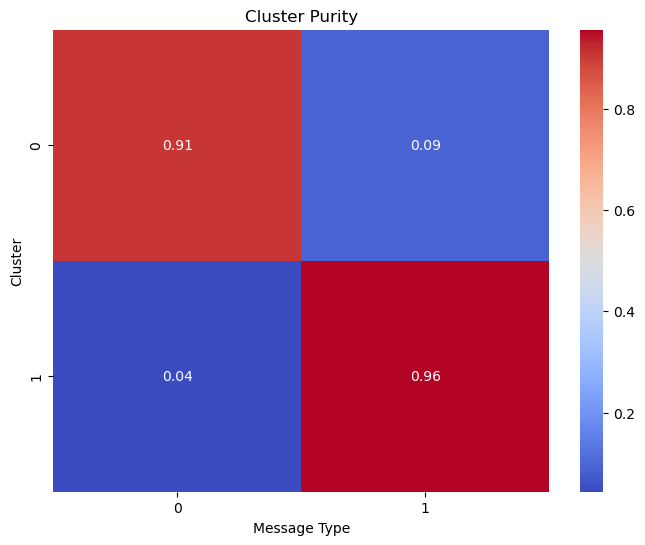

In [49]:
# Calculate the proportion of spam and ham in each cluster
cluster_purity = under_df.groupby('cluster_kmeans')['Target'].value_counts(normalize=True).unstack(fill_value=0)

plt.figure(figsize=(8, 6))
sns.heatmap(cluster_purity, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Cluster Purity')
plt.xlabel('Message Type')
plt.ylabel('Cluster')
plt.show()

### Evaluation on the Unbalanced dataset

In [50]:
# Apply KMeans to the original dataset
y_original = df['Target']
# kmeans_original = KMeans(n_clusters=2, random_state=42)
original_clusters = kmeans.fit_predict(scaled_data)
y_pred = kmeans.labels_

# Map cluster labels to target labels (use the majority class in each cluster)
cluster_mapping = {}
for cluster_id in np.unique(original_clusters):
    true_labels_in_cluster = y_original[original_clusters == cluster_id]
    majority_class = true_labels_in_cluster.value_counts().idxmax()
    cluster_mapping[cluster_id] = majority_class

# Map the cluster labels to match the target labels
mapped_labels = np.array([cluster_mapping[label] for label in original_clusters])

# Confusion Matrix
conf_matrix = confusion_matrix(y_original, mapped_labels)
print("Confusion Matrix (Original Data):")
print(conf_matrix)

# Cluster Purity
purity_matrix = pd.crosstab(original_clusters, y_original, normalize='index')
print("Cluster Purity Matrix (Original Data):")
print(purity_matrix)

Confusion Matrix (Original Data):
[[4825    0]
 [ 747    0]]
Cluster Purity Matrix (Original Data):
Target         0         1
row_0                     
0       0.994231  0.005769
1       0.753701  0.246299


In [51]:
from sklearn.metrics import balanced_accuracy_score, f1_score

In [52]:
# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_original, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

# F1-Score (for the positive class, assuming "1" is the spam class)
f1 = f1_score(y_original, y_pred, pos_label=1)  # "1" is the label for spam
print(f"F1-Score: {f1:.4f}")

Balanced Accuracy: 0.7578
F1-Score: 0.3937


## Interpretation of Clustering Method's Results
* Method chosen: K-Means
* Try: TF-IDF and LSA